# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.52KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

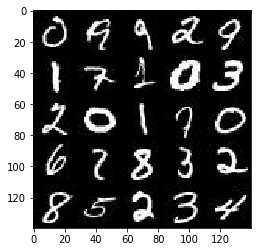

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

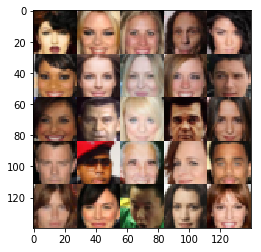

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [191]:
import math

def discriminator_layer_first(images, out_depth, kernel, stride, leaky_alpha=0.2):
    # Input layer is 28x28x3
    in_size = (28, 28, 3)
    
    size = (math.ceil(in_size[0] / stride),
            math.ceil(in_size[1] / stride),
            out_depth)
    
    layer = tf.layers.conv2d(images, size[2], kernel, strides=stride, padding='same')
    layer = tf.maximum(leaky_alpha * layer, layer)
    
#     print("Discriminator: first layer: size:", size)
    
    return layer, size

def discriminator_layer_i(prev_layer, in_size, training, kernel, stride, normalize, leaky_alpha=0.2):
    size = (math.ceil(in_size[0] / stride),
            math.ceil(in_size[1] / stride),
            in_size[2] * 2)
    
    layer = tf.layers.conv2d(prev_layer, size[2], kernel, strides=stride, padding='same')
    if normalize:
        layer = tf.layers.batch_normalization(layer, training=training)
    layer = tf.maximum(leaky_alpha * layer, layer)

#     print("Discriminator: middle layer: size:", size)
    
    return layer, size
    
def discriminator_layer_last(prev_layer, in_size):
    flat = tf.reshape(prev_layer, (-1, in_size[0]*in_size[1]*in_size[2]))
    logits = tf.layers.dense(flat, 1)
    
#     print("Discriminator: last layer: size:", 1)
    
    return logits

def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28
        layer, size = discriminator_layer_first(images,
                                                out_depth=64,
                                                kernel=5,
                                                stride=2,
                                                leaky_alpha=0.2)
        # now: 14x14
        
        layer, size = discriminator_layer_i(layer,
                                            size,
                                            training=True,
                                            kernel=5,
                                            stride=2,
                                            normalize=True,
                                            leaky_alpha=0.2)
        # now: 7x7
        
#         layer, size = discriminator_layer_i(layer,
#                                             size,
#                                             training=True,
#                                             kernel=3,
#                                             stride=2,
#                                             normalize=True,
#                                             leaky_alpha=0.2)
#         # now: 4x4

        # Flatten it
        logits = discriminator_layer_last(layer,
                                          size)
        
        out = tf.sigmoid(logits)
        
    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [192]:
def generator_layer_first(z, training, out_depth, normalize, leaky_alpha=0.2):
    size = (7, 7, out_depth)
    
    # First fully connected layer
    layer = tf.layers.dense(z, size[0]*size[1]*size[2])

    # Reshape it to start the convolutional stack
    layer = tf.reshape(layer, (-1, *size))
    if normalize:
        layer = tf.layers.batch_normalization(layer, training=training)
    layer = tf.maximum(leaky_alpha * layer, layer)
    
#     print("Generator: first layer: size:", size)
    
    return layer, size

def generator_layer_i(prev_layer, in_size, training, kernel, stride, normalize, leaky_alpha=0.2):
    size = (in_size[0] * stride,
            in_size[1] * stride,
            math.ceil(in_size[2] / stride))
    
    layer = tf.layers.conv2d_transpose(prev_layer, size[2], kernel, strides=stride, padding='same')
    if normalize:
        layer = tf.layers.batch_normalization(layer, training=training)
    layer = tf.maximum(leaky_alpha * layer, layer)

#     print("Generator: middle layer: size:", size)
    
    return layer, size
    
def generator_layer_last(prev_layer, in_size, out_channel_dim, kernel, stride):
    size = (in_size[0] * stride,
            in_size[1] * stride,
            out_channel_dim)
    
    logits = tf.layers.conv2d_transpose(prev_layer, out_channel_dim, kernel, strides=stride, padding='same')

#     print("Generator: last layer: size:", size)
    
    return logits, size
    
    
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        layer, size = generator_layer_first(z,
                                            is_train,
                                            out_depth=512,
                                            normalize=True,
                                            leaky_alpha=0.2)
        # now: 7x7
        
        layer, size = generator_layer_i(layer,
                                        size,
                                        is_train,
                                        kernel=5,
                                        stride=2,
                                        normalize=True,
                                        leaky_alpha=0.2)
        # now: 14x14
        
        layer, size = generator_layer_i(layer,
                                        size,
                                        is_train,
                                        kernel=5,
                                        stride=2,
                                        normalize=True,
                                        leaky_alpha=0.2)
        # now: 28x28
        
        # Output layer
        logits, size = generator_layer_last(layer,
                                            size,
                                            out_channel_dim=out_channel_dim,
                                            kernel=5,
                                            stride=1)
        # now: 28x28
        
        assert size[0] == 28, "size[0] != 28: %r" % size[0]
        assert size[1] == 28, "size[1] != 28: %r" % size[1]
        
        out = tf.tanh(logits)
        
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [193]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [194]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [195]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [196]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    # Config
    print_every = 20
    show_every = 100
    show_n_images = 25
    
    # Aliases
    out_channel_dim = data_shape[3]
        
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)    
    
    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                # As suggested by @rahul_ahuja on the forum:
                # works better when pixels within range [-1, 1]
                batch_images *= 2
                
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, show_n_images, input_z, out_channel_dim, data_image_mode)
        
        print("=== final output ===")
        show_generator_output(sess, show_n_images, input_z, out_channel_dim, data_image_mode)    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.3371... Generator Loss: 0.5174
Epoch 1/2... Discriminator Loss: 1.7946... Generator Loss: 0.5415
Epoch 1/2... Discriminator Loss: 1.6696... Generator Loss: 0.5699
Epoch 1/2... Discriminator Loss: 1.6977... Generator Loss: 0.5381
Epoch 1/2... Discriminator Loss: 1.6810... Generator Loss: 0.5068


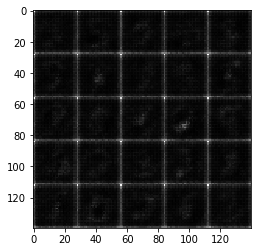

Epoch 1/2... Discriminator Loss: 1.7092... Generator Loss: 0.4850
Epoch 1/2... Discriminator Loss: 1.5675... Generator Loss: 0.5342
Epoch 1/2... Discriminator Loss: 1.5159... Generator Loss: 0.5978
Epoch 1/2... Discriminator Loss: 1.5315... Generator Loss: 0.6145
Epoch 1/2... Discriminator Loss: 1.4958... Generator Loss: 0.7290


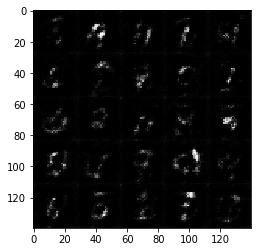

Epoch 1/2... Discriminator Loss: 1.4550... Generator Loss: 0.6597
Epoch 1/2... Discriminator Loss: 1.3553... Generator Loss: 0.7504
Epoch 1/2... Discriminator Loss: 1.4159... Generator Loss: 0.8067
Epoch 1/2... Discriminator Loss: 1.3170... Generator Loss: 0.7310
Epoch 1/2... Discriminator Loss: 1.3064... Generator Loss: 0.8252


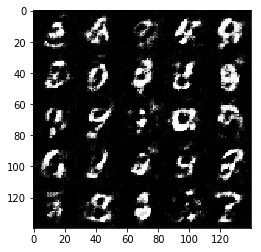

Epoch 1/2... Discriminator Loss: 1.3171... Generator Loss: 0.7356
Epoch 1/2... Discriminator Loss: 1.2850... Generator Loss: 0.7346
Epoch 1/2... Discriminator Loss: 1.2595... Generator Loss: 0.8551
Epoch 1/2... Discriminator Loss: 1.2650... Generator Loss: 0.7579
Epoch 1/2... Discriminator Loss: 1.3198... Generator Loss: 0.8480


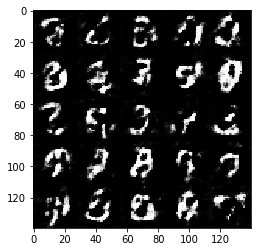

Epoch 1/2... Discriminator Loss: 1.2725... Generator Loss: 0.8516
Epoch 1/2... Discriminator Loss: 1.2354... Generator Loss: 0.8247
Epoch 1/2... Discriminator Loss: 1.2016... Generator Loss: 0.9508
Epoch 2/2... Discriminator Loss: 1.1772... Generator Loss: 0.9583
Epoch 2/2... Discriminator Loss: 1.2526... Generator Loss: 0.7428


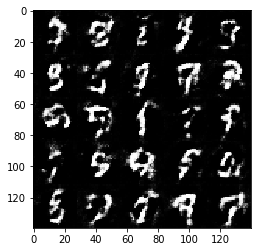

Epoch 2/2... Discriminator Loss: 1.2703... Generator Loss: 0.5824
Epoch 2/2... Discriminator Loss: 1.2141... Generator Loss: 0.6792
Epoch 2/2... Discriminator Loss: 1.3058... Generator Loss: 0.5501
Epoch 2/2... Discriminator Loss: 1.1420... Generator Loss: 0.8863
Epoch 2/2... Discriminator Loss: 1.2356... Generator Loss: 0.6163


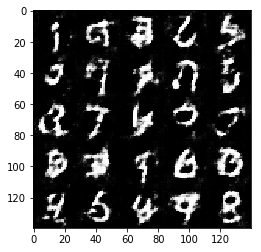

Epoch 2/2... Discriminator Loss: 1.3291... Generator Loss: 0.5353
Epoch 2/2... Discriminator Loss: 1.3507... Generator Loss: 0.5183
Epoch 2/2... Discriminator Loss: 1.3340... Generator Loss: 0.7953
Epoch 2/2... Discriminator Loss: 1.3161... Generator Loss: 0.8081
Epoch 2/2... Discriminator Loss: 1.3286... Generator Loss: 0.8189


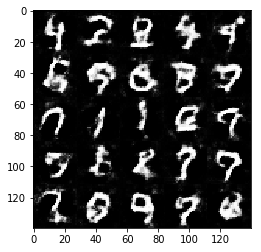

Epoch 2/2... Discriminator Loss: 1.3098... Generator Loss: 0.7727
Epoch 2/2... Discriminator Loss: 1.3707... Generator Loss: 0.8890
Epoch 2/2... Discriminator Loss: 1.3590... Generator Loss: 0.7172
Epoch 2/2... Discriminator Loss: 1.3813... Generator Loss: 0.6001
Epoch 2/2... Discriminator Loss: 1.3933... Generator Loss: 0.5800


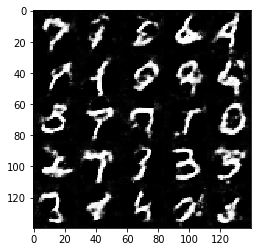

Epoch 2/2... Discriminator Loss: 1.3301... Generator Loss: 0.6718
Epoch 2/2... Discriminator Loss: 1.3420... Generator Loss: 0.6484
Epoch 2/2... Discriminator Loss: 1.3594... Generator Loss: 0.9884
Epoch 2/2... Discriminator Loss: 1.3471... Generator Loss: 0.8423
Epoch 2/2... Discriminator Loss: 1.3294... Generator Loss: 0.7467


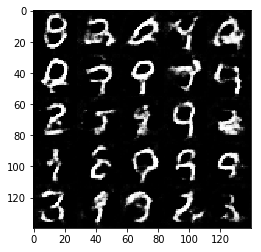

Epoch 2/2... Discriminator Loss: 1.4093... Generator Loss: 0.7782
=== final output ===


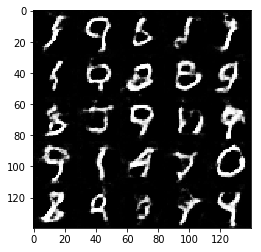

In [197]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.2

tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.7535... Generator Loss: 0.0212
Epoch 1/1... Discriminator Loss: 2.2741... Generator Loss: 0.3445
Epoch 1/1... Discriminator Loss: 2.3229... Generator Loss: 0.3058
Epoch 1/1... Discriminator Loss: 1.9388... Generator Loss: 0.4874
Epoch 1/1... Discriminator Loss: 1.9597... Generator Loss: 0.4925


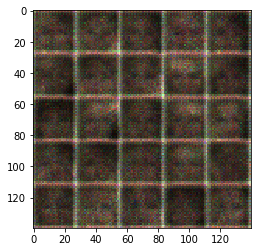

Epoch 1/1... Discriminator Loss: 1.6661... Generator Loss: 0.6394
Epoch 1/1... Discriminator Loss: 1.7320... Generator Loss: 0.6171
Epoch 1/1... Discriminator Loss: 1.2661... Generator Loss: 0.8933
Epoch 1/1... Discriminator Loss: 0.9996... Generator Loss: 1.0580
Epoch 1/1... Discriminator Loss: 1.0370... Generator Loss: 1.7669


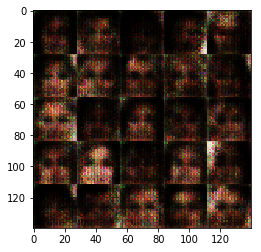

Epoch 1/1... Discriminator Loss: 0.7615... Generator Loss: 1.6173
Epoch 1/1... Discriminator Loss: 1.0613... Generator Loss: 2.3408
Epoch 1/1... Discriminator Loss: 0.6405... Generator Loss: 2.3917
Epoch 1/1... Discriminator Loss: 1.5666... Generator Loss: 0.6686
Epoch 1/1... Discriminator Loss: 0.7561... Generator Loss: 1.6597


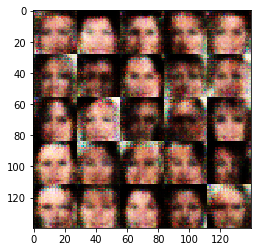

Epoch 1/1... Discriminator Loss: 1.2292... Generator Loss: 1.7568
Epoch 1/1... Discriminator Loss: 1.2497... Generator Loss: 1.1473
Epoch 1/1... Discriminator Loss: 0.6958... Generator Loss: 2.7411
Epoch 1/1... Discriminator Loss: 1.2003... Generator Loss: 0.8823
Epoch 1/1... Discriminator Loss: 0.9198... Generator Loss: 2.3642


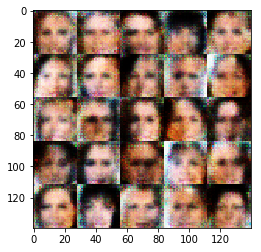

Epoch 1/1... Discriminator Loss: 1.0503... Generator Loss: 0.6817
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.6574
Epoch 1/1... Discriminator Loss: 1.5793... Generator Loss: 0.3129
Epoch 1/1... Discriminator Loss: 1.1340... Generator Loss: 0.6091
Epoch 1/1... Discriminator Loss: 0.9719... Generator Loss: 0.9532


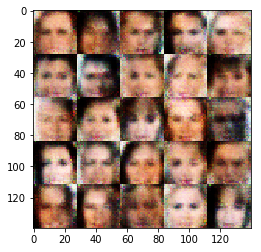

Epoch 1/1... Discriminator Loss: 1.0972... Generator Loss: 0.6495
Epoch 1/1... Discriminator Loss: 0.8630... Generator Loss: 1.0376
Epoch 1/1... Discriminator Loss: 1.8839... Generator Loss: 0.2741
Epoch 1/1... Discriminator Loss: 0.8122... Generator Loss: 1.7756
Epoch 1/1... Discriminator Loss: 1.2739... Generator Loss: 1.6431


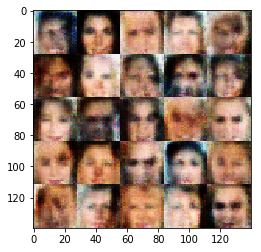

Epoch 1/1... Discriminator Loss: 1.3057... Generator Loss: 0.8492
Epoch 1/1... Discriminator Loss: 0.5336... Generator Loss: 2.0194
Epoch 1/1... Discriminator Loss: 1.5054... Generator Loss: 0.7154
Epoch 1/1... Discriminator Loss: 1.5131... Generator Loss: 0.8595
Epoch 1/1... Discriminator Loss: 1.2769... Generator Loss: 0.6274


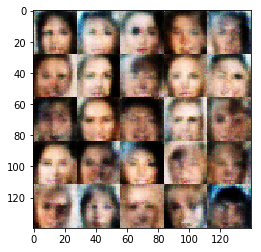

Epoch 1/1... Discriminator Loss: 0.9710... Generator Loss: 1.1445
Epoch 1/1... Discriminator Loss: 1.2447... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.1118... Generator Loss: 1.1847
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.5255
Epoch 1/1... Discriminator Loss: 1.1829... Generator Loss: 0.8202


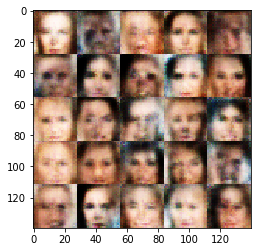

Epoch 1/1... Discriminator Loss: 1.3026... Generator Loss: 0.9224
Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 0.9040
Epoch 1/1... Discriminator Loss: 1.2788... Generator Loss: 0.9667
Epoch 1/1... Discriminator Loss: 1.3160... Generator Loss: 0.6361
Epoch 1/1... Discriminator Loss: 1.3488... Generator Loss: 0.8322


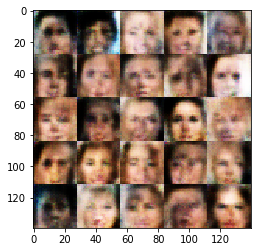

Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.5351
Epoch 1/1... Discriminator Loss: 1.3084... Generator Loss: 0.8277
Epoch 1/1... Discriminator Loss: 1.5218... Generator Loss: 0.5062
Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.7049
Epoch 1/1... Discriminator Loss: 1.2656... Generator Loss: 0.6976


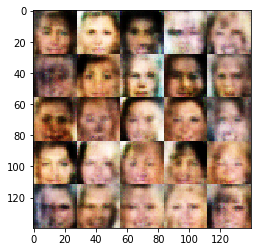

Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 0.8612
Epoch 1/1... Discriminator Loss: 1.5030... Generator Loss: 0.4209
Epoch 1/1... Discriminator Loss: 1.3055... Generator Loss: 0.7264
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.5828
Epoch 1/1... Discriminator Loss: 1.1911... Generator Loss: 1.0719


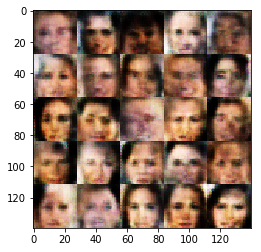

Epoch 1/1... Discriminator Loss: 1.1525... Generator Loss: 0.9909
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.4854
Epoch 1/1... Discriminator Loss: 1.1501... Generator Loss: 1.4853
Epoch 1/1... Discriminator Loss: 1.1341... Generator Loss: 0.9792
Epoch 1/1... Discriminator Loss: 1.3034... Generator Loss: 0.8441


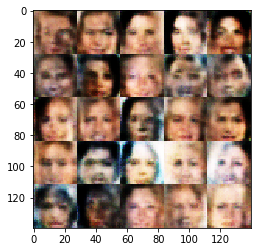

Epoch 1/1... Discriminator Loss: 1.2120... Generator Loss: 1.2990
Epoch 1/1... Discriminator Loss: 1.1313... Generator Loss: 0.8101
Epoch 1/1... Discriminator Loss: 1.2176... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 0.6269
Epoch 1/1... Discriminator Loss: 1.5343... Generator Loss: 0.4200


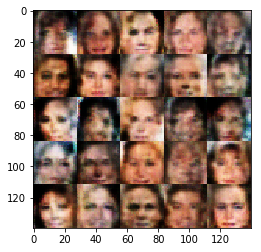

Epoch 1/1... Discriminator Loss: 1.2645... Generator Loss: 0.6687
Epoch 1/1... Discriminator Loss: 1.2015... Generator Loss: 0.9197
Epoch 1/1... Discriminator Loss: 1.1180... Generator Loss: 1.2677
Epoch 1/1... Discriminator Loss: 1.1432... Generator Loss: 0.7996
Epoch 1/1... Discriminator Loss: 1.1944... Generator Loss: 0.7462


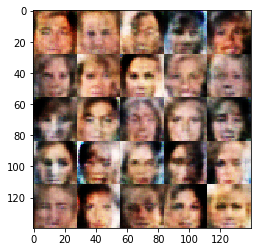

Epoch 1/1... Discriminator Loss: 1.6556... Generator Loss: 0.4033
Epoch 1/1... Discriminator Loss: 1.0824... Generator Loss: 1.1101
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.9092
Epoch 1/1... Discriminator Loss: 1.2458... Generator Loss: 0.9553
Epoch 1/1... Discriminator Loss: 1.2139... Generator Loss: 1.1218


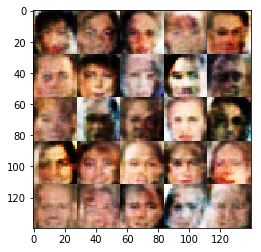

Epoch 1/1... Discriminator Loss: 1.2447... Generator Loss: 1.1882
Epoch 1/1... Discriminator Loss: 1.1694... Generator Loss: 0.9352
Epoch 1/1... Discriminator Loss: 1.4614... Generator Loss: 0.4414
Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.4643
=== final output ===


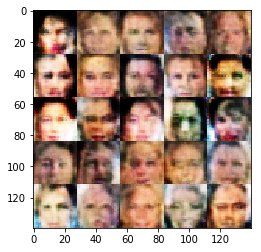

In [198]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.